# p-Hacking and Multiple Comparisons Bias

In [21]:
import numpy as np
import pandas as pd

import scipy.stats as stats
import matplotlib.pyplot as plt

jtplot.style(figsize=(15, 9))

## One Experiment

In [2]:
df = pd.DataFrame()

N = 20
T = 100

for i in range(N):
    X = np.random.normal(0, 1, T)
    X = pd.Series(X)
    name = 'X%s' % i
    df[name] = X

In [3]:
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19
0,-1.624093,-0.173540,-0.305305,-1.925479,0.143485,2.735556,-0.516784,0.741076,-1.559883,0.282156,1.226179,1.435014,-1.848752,-0.578208,0.963319,0.993480,1.249336,-0.732804,-0.193733,-0.684990
1,0.540092,1.323208,-0.580312,-0.716968,1.003919,-0.016201,1.466824,-0.885235,-2.372765,0.345224,0.443665,-1.016739,-0.681614,-0.315438,1.665254,1.348430,0.665705,-2.148925,0.609963,-0.455012
2,0.904078,0.989198,0.071811,-0.394764,0.995742,0.527720,-1.013019,-0.148739,0.359863,-1.300544,0.498174,-0.123302,-1.247467,-1.552051,0.701180,1.189831,1.172374,0.302297,1.251860,0.566709
3,1.470607,0.798765,0.357212,-0.286237,-0.389440,-0.412889,-0.395488,0.150712,-1.228355,0.926094,1.461555,1.196264,-1.305834,0.070709,-1.728207,-0.339210,1.874273,1.920190,-2.063870,0.873727
4,-0.008099,0.002090,1.545660,0.599790,0.163612,-0.260818,0.156217,0.333777,-0.061620,-1.810384,0.606600,1.203776,0.035893,0.347496,-1.334287,-0.788918,0.257956,-1.005183,-1.115861,0.831415


In [9]:
cutoff = 0.05

significant_pairs = []

for i in range(N):
    for j in range(i+1, N):
        Xi = df.iloc[:, i]
        Xj = df.iloc[:, j]
        
        results = stats.spearmanr(Xi, Xj)
        
        pvalue = results[1]
        
        if pvalue < cutoff:
            significant_pairs.append((i, j))

In [14]:
# what we expected
(N * (N-1) / 2) * 0.05

9.5

In [15]:
# what we actually got
len(significant_pairs)

12

## Many Experiments

In [17]:
def do_experiment(N, T, cutoff=0.05):
    df = pd.DataFrame()

    # Make random data
    for i in range(N):
        X = np.random.normal(0, 1, T)
        X = pd.Series(X)
        name = 'X%s' % i
        df[name] = X

    significant_pairs = []

    # Look for relationships
    for i in range(N):
        for j in range(i+1, N):
            Xi = df.iloc[:, i]
            Xj = df.iloc[:, j]

            results = stats.spearmanr(Xi, Xj)

            pvalue = results[1]

            if pvalue < cutoff:
                significant_pairs.append((i, j))
    
    return significant_pairs


num_experiments = 100

results = np.zeros((num_experiments,))

for i in range(num_experiments):
    # Run a single experiment
    result = do_experiment(20, 100, cutoff=0.05)
    
    # Count how many pairs
    n = len(result)
    
    # Add to array
    results[i] = n

In [18]:
np.mean(results)

9.01

## Visualizing

In [19]:
def get_pvalues_from_experiment(N, T):
    df = pd.DataFrame()

    # Make random data
    for i in range(N):
        X = np.random.normal(0, 1, T)
        X = pd.Series(X)
        name = 'X%s' % i
        df[name] = X

    pvalues = []

    # Look for relationships
    for i in range(N):
        for j in range(i+1, N):
            Xi = df.iloc[:, i]
            Xj = df.iloc[:, j]

            results = stats.spearmanr(Xi, Xj)
            pvalue = results[1]
            pvalues.append(pvalue)
    
    return pvalues

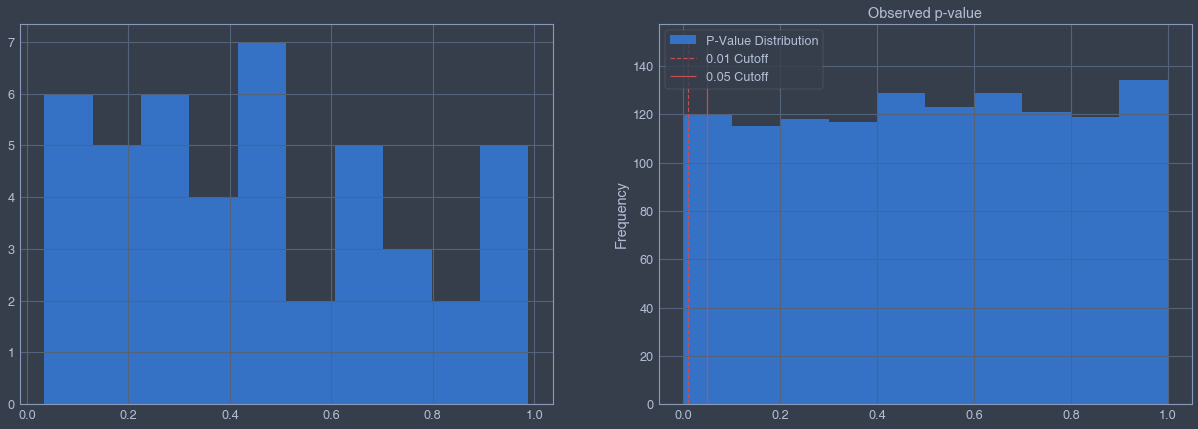

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(21, 7))

pvalues = get_pvalues_from_experiment(10, 100)
ax[0].hist(pvalues)
plt.ylabel('Frequency')
plt.title('Observed p-value');

pvalues = get_pvalues_from_experiment(50, 100)
ax[1].vlines(0.01, 0, 150, colors='r', linestyle='--', label='0.01 Cutoff')
ax[1].vlines(0.05, 0, 150, colors='r', label='0.05 Cutoff')
ax[1].hist(pvalues, label='P-Value Distribution')
plt.legend()
plt.ylabel('Frequency')
plt.title('Observed p-value');

In [29]:
num_experiments = 100

results = np.zeros((num_experiments,))

for i in range(num_experiments):
    # Run a single experiment
    result = do_experiment(20, 100, cutoff=0.01)
    
    # Count how many pairs
    n = len(result)
    
    # Add to array
    results[i] = n

In [30]:
np.mean(results), (N * (N-1) / 2) * 0.01

(1.86, 1.9000000000000001)

## Reducing Multiple Comparisons Bias

### Example: Bon Ferroni Correction

In [32]:
num_experiments = 100

results = np.zeros((num_experiments,))
results_bf = np.zeros((num_experiments,))

N = 20
T = 100

desired_level = 0.05

num_tests = N * (N - 1) / 2

new_cutoff = desired_level / num_tests

for i in range(num_experiments):
    # Run a single experiment
    result = do_experiment(N, T, cutoff=desired_level)
    result_bf = do_experiment(N, T, cutoff=new_cutoff)
    
    # Count how many pairs
    n = len(result)
    n_bf = len(result_bf)
    
    # Add to array
    results[i] = n
    results_bf[i] = n_bf


In [35]:
results

array([ 7., 13.,  9.,  9., 12., 11.,  9., 14.,  6.,  8.,  9.,  3., 10.,
        7., 11.,  9., 11.,  5., 11., 11., 10., 13., 14., 10., 12., 13.,
        7.,  5., 12.,  8., 13.,  6., 12., 13., 16.,  9.,  8.,  9., 14.,
       12., 13.,  6.,  3., 11.,  6.,  8.,  9.,  5., 11.,  5.,  7.,  5.,
        9., 12., 10., 10.,  4.,  9., 10., 11.,  8.,  9.,  9.,  5., 10.,
        4., 10., 11., 10., 11., 11., 13.,  2.,  4.,  8., 12.,  9., 13.,
        9., 12.,  9., 12.,  8., 12., 12., 11.,  8.,  7.,  3., 11.,  8.,
       10., 10., 12.,  8.,  9.,  8., 11., 12., 13.])

In [36]:
results_bf

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [34]:
np.mean(results), np.mean(results_bf), (N * (N-1) / 2) * 0.05

(9.39, 0.02, 9.5)